In [1]:
from transformers import BertTokenizer, TFBertForTokenClassification
from torch.utils.data import DataLoader , Dataset
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from transformers import AutoModel, BertTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments ,  AutoTokenizer
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
from transformers.data.processors.utils import InputFeatures
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import BertModel
from tqdm import tqdm
from transformers import AdamW
from keras.models import Model
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder

2024-05-17 20:19:48.081122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 20:19:48.081248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 20:19:48.249780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path =  '/kaggle/input/traindata/train_data.txt'
val_path =  '/kaggle/input/validation/validation_data.txt'
df = pd.read_csv(train_path, sep="\t", names=["token", "tag"])
val_df = pd.read_csv(val_path, sep="\t", names=["token", "tag"])
val_labels = val_df["tag"].unique()
train_labels = df["tag"].unique()

In [3]:
all_labels = np.unique(np.concatenate((train_labels, val_labels)))
print(len(all_labels))
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
train_label_encoded= label_encoder.transform(train_labels)
val_label_encoded= label_encoder.transform(val_labels)
train_labels = train_label_encoded.tolist()
val_labels= val_label_encoded.tolist()

95


In [4]:
max_length = df["token"].str.len().max()
model_name = 'aubmindlab/bert-base-arabertv02'
arabert_model = AutoModel.from_pretrained(model_name)

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [5]:
label_map = {label: index for label, index in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}

print(label_map)

{'B-AIRPORT': 0, 'B-BOUNDARY': 1, 'B-BUILDING-OR-GROUNDS': 2, 'B-CAMP': 3, 'B-CARDINAL': 4, 'B-CELESTIAL': 5, 'B-CLUSTER': 6, 'B-COM': 7, 'B-CONTINENT': 8, 'B-COUNTRY': 9, 'B-CURR': 10, 'B-Cluster': 11, 'B-DATE': 12, 'B-EDU': 13, 'B-ENT': 14, 'B-EVENT': 15, 'B-GOV': 16, 'B-LAND': 17, 'B-LAND-REGION-NATURAL': 18, 'B-LANGUAGE': 19, 'B-LAW': 20, 'B-MED': 21, 'B-MONEY': 22, 'B-NEIGHBORHOOD': 23, 'B-NONGOV': 24, 'B-NORP': 25, 'B-OCC': 26, 'B-ORDINAL': 27, 'B-ORG': 28, 'B-PATH': 29, 'B-PERCENT': 30, 'B-PERS': 31, 'B-PLANT': 32, 'B-PRODUCT': 33, 'B-QUANTITY': 34, 'B-REGION-GENERAL': 35, 'B-REGION-INTERNATIONAL': 36, 'B-REL': 37, 'B-SCI': 38, 'B-SPO': 39, 'B-SPORT': 40, 'B-STATE-OR-PROVINCE': 41, 'B-SUBAREA-FACILITY': 42, 'B-TIME': 43, 'B-TOWN': 44, 'B-UNIT': 45, 'B-WATER-BODY': 46, 'B-WEBSITE': 47, 'I-AIRPORT': 48, 'I-BOUNDARY': 49, 'I-BUILDING-OR-GROUNDS': 50, 'I-CAMP': 51, 'I-CARDINAL': 52, 'I-CLUSTER': 53, 'I-COM': 54, 'I-CONTINENT': 55, 'I-COUNTRY': 56, 'I-CURR': 57, 'I-Cluster': 58, 'I-D

In [6]:
reversed_label_map = {v: k for k, v in label_map.items()}

In [7]:
class BERTDataset(Dataset):
    def __init__(self, data, model_name, max_len, label_map):
      super(BERTDataset).__init__()
      self.data = data
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map


    def __len__(self):
      # return len(self.text)
      return len(self.data)

    def __getitem__(self,item):
      text = str(self.data[item][0])
      target = self.data[item][1]

        # Tokenize the text
      encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
      input_ids = encoding['input_ids'].squeeze(0)
      attention_mask = encoding['attention_mask'].squeeze(0)
      label_id = self.label_map[target]

    
      return{
         'input_ids': input_ids,
          'attention_mask': attention_mask,
            'labels': label_id
      }

In [8]:
train_dataset = BERTDataset(df[['token', 'tag']].values.tolist(), model_name, max_length, label_map)

tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [9]:
val_dataset=BERTDataset(val_df[['token', 'tag']].values.tolist(), model_name, max_length, label_map)

In [10]:
class ArabertModel(nn.Module):
    def __init__(self, arabert_model, num_classes):
        super(ArabertModel, self).__init__()
        self.arabert_model = arabert_model  
        self.lstm1 = nn.LSTM(input_size=768, hidden_size=128, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=64, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.arabert_model(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        lstm1_output, _ = self.lstm1(sequence_output)
        lstm2_output, _ = self.lstm2(lstm1_output)
        lstm2_output = self.dropout(lstm2_output)
        logits = self.fc(lstm2_output[:, -1, :])  
        return logits



In [11]:
def calculate_accuracy(model, dataloader, device):
    model.eval()  
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask)
            _, predicted = torch.max(logits, dim=1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    return correct_predictions / total_predictions

In [12]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [13]:
num_classes = len(label_map)
model = ArabertModel(arabert_model, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
num_epochs = 10
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
#---------------------------------------------------------------------------------------------#
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_accuracy = calculate_accuracy(model, train_dataloader, device)
    val_accuracy = calculate_accuracy(model, val_dataloader, device)
    train_losses.append(epoch_loss / len(train_dataloader))
    val_losses.append(epoch_loss / len(val_dataloader))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_dataloader)}, "
          f"Training Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}")
    lr_scheduler.step(epoch_loss)
   


Epoch 1/10, Loss: 1.6211408865406138, Training Accuracy: 0.73, Validation Accuracy: 0.72
Epoch 2/10, Loss: 1.579192640795105, Training Accuracy: 0.73, Validation Accuracy: 0.72
Epoch 3/10, Loss: 1.5769916302399618, Training Accuracy: 0.73, Validation Accuracy: 0.72
Epoch 4/10, Loss: 1.5670661178356844, Training Accuracy: 0.73, Validation Accuracy: 0.72
Epoch 5/10, Loss: 1.5633168378856752, Training Accuracy: 0.73, Validation Accuracy: 0.72
Epoch 6/10, Loss: 1.560439433935806, Training Accuracy: 0.73, Validation Accuracy: 0.72
Epoch 7/10, Loss: 1.5597033393337352, Training Accuracy: 0.73, Validation Accuracy: 0.72
Epoch 8/10, Loss: 1.557299090680187, Training Accuracy: 0.73, Validation Accuracy: 0.72
Epoch 9/10, Loss: 1.5564261747959474, Training Accuracy: 0.73, Validation Accuracy: 0.72
Epoch 10/10, Loss: 1.5537209060152524, Training Accuracy: 0.73, Validation Accuracy: 0.72


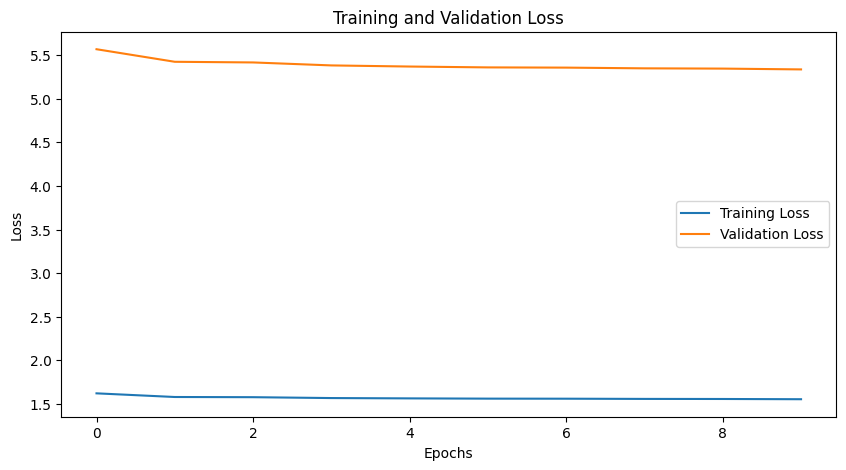

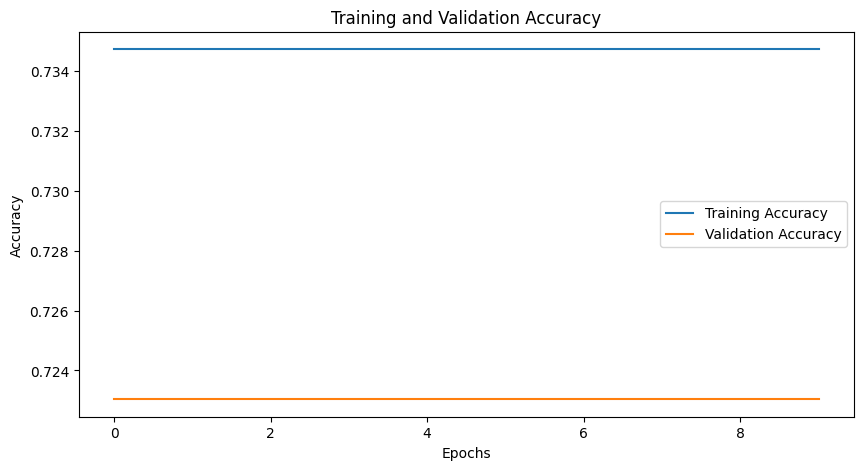

In [14]:
import matplotlib.pyplot as plt
# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
true_labels = []
predicted_labels = []
model.eval()
with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
precision = precision_score(true_labels, predicted_labels, average='micro')
recall = recall_score(true_labels, predicted_labels, average='micro')
f1 = f1_score(true_labels, predicted_labels, average='micro')

print("Validation Precision:", precision)
print("Validation Recall:", recall)
print("Validation Micro-F1:", f1)


Validation Precision: 0.7230378704720087
Validation Recall: 0.7230378704720087
Validation Micro-F1: 0.7230378704720087


In [16]:
test_path =  '/kaggle/input/traindata/test_set.txt'
test_df = pd.read_csv(test_path, sep="\t", names=["token"])
token_list = test_df["token"].tolist()

In [17]:
model.eval()

ArabertModel(
  (arabert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [18]:
class TestDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        return{
         'input_ids': input_ids,
          'attention_mask': attention_mask
      }
tokenizer = AutoTokenizer.from_pretrained(model_name)    
test_dataset = TestDataset(token_list[:90000], tokenizer, max_length)    
test_dataloader = DataLoader(test_dataset, batch_size=8)    

In [26]:
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        predictions.extend(predicted_labels)